In [21]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")


In [269]:
folder_path = '/nfs/home/jingt/dissertation-iceberg/data/trading_strat/ClOp_all'

# List to hold DataFrames
dfs = []

# Iterate over all files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        # Read each CSV file and append it to the list
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path)
        dfs.append(df)

# Concatenate all DataFrames
df = pd.concat(dfs, ignore_index=True)

In [270]:
params = pd.read_csv("/nfs/home/jingt/dissertation-iceberg/data/output_regression/pred_ClOp_ff_ib.csv")

In [271]:
len(df['ticker'].unique())

20

In [272]:
ticker_lst = ['AES', 'ALB', 'AOS', 'APA', 'BEN', 'BXP', 'CPB',
              'DVA', 'FFIV', 'FRT', 'HII', 'HRL', 'HSIC', 'INCY',
              'MHK', 'NWSA', 'PNW', 'RL', 'TAP', 'WYNN']

In [273]:
df['pnl'] = np.sign(df['signal']) * df['fret_ClOp']

In [274]:
df['datetime_bins'] = pd.to_datetime(df['datetime_bins'])

In [275]:
trading_days = df['datetime_bins'].unique()

In [276]:
def top_performers_df(df, dates, n_tickers=5):
    df_month = df[df['datetime_bins'].isin(dates)]
    pnl_ticker_lst = []
    for ticker in ticker_lst:
        df_month_ticker = df_month[df_month['ticker']==ticker]
        pnl_ticker_lst.append(df_month_ticker['pnl'].sum())
    pnl_ticker_df = pd.DataFrame({'ticker': ticker_lst, 'pnl': pnl_ticker_lst})
    return pnl_ticker_df.sort_values(by='pnl', ascending=False)['ticker'][:n_tickers].to_list()

In [277]:
def calc_portfolio(df, date, top_ticker_lst):
    df_filtered = df[(df['ticker'].isin(top_ticker_lst)) & (df['datetime_bins'] == date)]
    df_filtered['signal_rank_top'] = df_filtered.groupby('datetime_bins')['signal'].rank(method='first', ascending=False)
    
    top_signals = df_filtered[df_filtered['signal_rank_top'] == 1]
    top_signals = top_signals[top_signals['signal'] > 0]

    bot_signals = df_filtered[df_filtered['signal_rank_top'] == len(top_ticker_lst)]
    bot_signals = bot_signals[bot_signals['signal'] < 0]

    result = top_signals['pnl'].sum() + bot_signals['pnl'].sum()

    return result, top_signals, bot_signals, top_ticker_lst

In [278]:
result_lst = []
top_signals_lst = []
bot_signals_lst = []
top_ticker_lst = []

for day in trading_days[20:]:
    prev_days = [i for i in trading_days if i < day][-20:]
    top_performers = top_performers_df(df, prev_days, n_tickers=5)
    result, top_signals, bot_signals, top_tickers = calc_portfolio(df, day, top_performers)
    result_lst.append(result)
    top_signals_lst.append(top_signals)
    bot_signals_lst.append(bot_signals)
    top_ticker_lst.append(top_tickers)

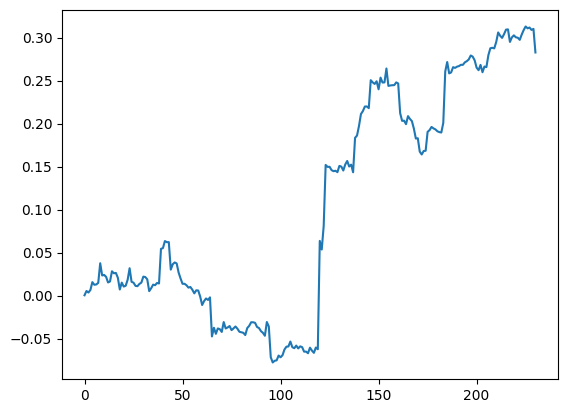

In [279]:
plt.plot(np.cumsum(result_lst))

In [280]:
from scipy.stats import norm
from scipy.stats import skew, kurtosis

def sharpe_test(returns):
    # Calculate the Sharpe ratio
    sharpe_ratio = np.mean(returns) / np.std(returns, ddof=1)
    
    # Number of observations
    T = len(returns)
    
    # Calculate skewness and kurtosis
    g3 = skew(returns)
    g4 = kurtosis(returns, fisher=False)  # fisher=False to match R's kurtosis (which includes the 3)
    
    # Calculate the modified Sharpe ratio statistic
    denominator = np.sqrt((1 - g3 * sharpe_ratio + (g4 - 1) * (sharpe_ratio ** 2) / 4) / (T - 1))
    modified_sharpe_stat = sharpe_ratio / denominator
    # Calculate the two-tailed p-value
    p_value = 2 * min(norm.cdf(modified_sharpe_stat), 1 - norm.cdf(modified_sharpe_stat))
    
    annual_sharpe = sharpe_ratio * np.sqrt(252)
        
    return annual_sharpe, modified_sharpe_stat, p_value

In [281]:
sharpe_test(result_lst)

(1.4047664875744732, 1.5808634427421762, 0.11390926464137774)

In [282]:
def PPT(result_lst, trading_days):
    return sum(result_lst) / (2 * len(trading_days)) * 10000

In [283]:
PPT(result_lst, trading_days)

5.630630120134785

In [284]:
df_top_signals = pd.concat(top_signals_lst)
df_bot_signals = pd.concat(bot_signals_lst)
df_top_signals.set_index('datetime_bins', inplace=True)
df_bot_signals.set_index('datetime_bins', inplace=True)


In [285]:
df_top_ticker = df_top_signals.groupby('ticker')['pnl'].agg(['count', 'sum'])
df_bot_ticker = df_bot_signals.groupby('ticker')['pnl'].agg(['count', 'sum'])

# Reindex to fill missing indices with 0
df_top_ticker = df_top_ticker.reindex(ticker_lst, fill_value=0)
df_bot_ticker = df_bot_ticker.reindex(ticker_lst, fill_value=0)

In [286]:
df_ticker_PPT = (df_top_ticker['sum'] + df_bot_ticker['sum']) / (df_top_ticker['count'] + df_bot_ticker['count']) * 1000

In [287]:
df_ticker_PPT.to_frame()

,0
ticker,
AES,0.260946
ALB,2.516680
AOS,0.238099
APA,-1.848393
BEN,0.488008
BXP,0.528242
CPB,-0.278661
DVA,-0.706789
FFIV,0.458515


In [288]:
def SR(df_top_signals, df_bot_signals):
    SR_lst = []
    count_lst = []
    test_lst = []
    for ticker in ticker_lst:
        top_ticker = df_top_signals[df_top_signals['ticker'] == ticker]['pnl'].to_list()
        bot_ticker = df_bot_signals[df_bot_signals['ticker'] == ticker]['pnl'].to_list()

        ticker_pnl = top_ticker + bot_ticker
        ticker_pnl = np.array(ticker_pnl)
        ticker_count = len(ticker_pnl)
        _, test, _ = sharpe_test(ticker_pnl)
        test_lst.append(test)
        count_lst.append(ticker_count)
        SR_lst.append(np.mean(ticker_pnl) / np.std(ticker_pnl) * np.sqrt(252))
    
    return pd.DataFrame({'ticker': ticker_lst, 'SR': SR_lst, 'count': count_lst, 'test': test_lst})

In [289]:
SR(df_top_signals, df_bot_signals)

,ticker,SR,count,test
0,AES,0.886773,2,0.039500
1,ALB,13.989188,5,1.663325
2,AOS,1.492375,11,0.274274
3,APA,-3.814419,9,-0.647146
4,BEN,1.814200,25,0.559828
5,BXP,2.317501,12,0.485514
6,CPB,-1.463963,8,-0.217703
7,DVA,-1.498152,33,-0.669002
8,FFIV,3.973548,12,0.722955
9,FRT,-2.984224,9,-0.622337


In [308]:
df = pd.read_csv('/nfs/home/jingt/dissertation-iceberg/data/ClOp_statistics.csv')

In [309]:
df.dropna(axis=1, how='all', inplace=True)
df.dropna(axis=0, how='all', inplace=True)

In [316]:
df.set_index('ticker', inplace=True)

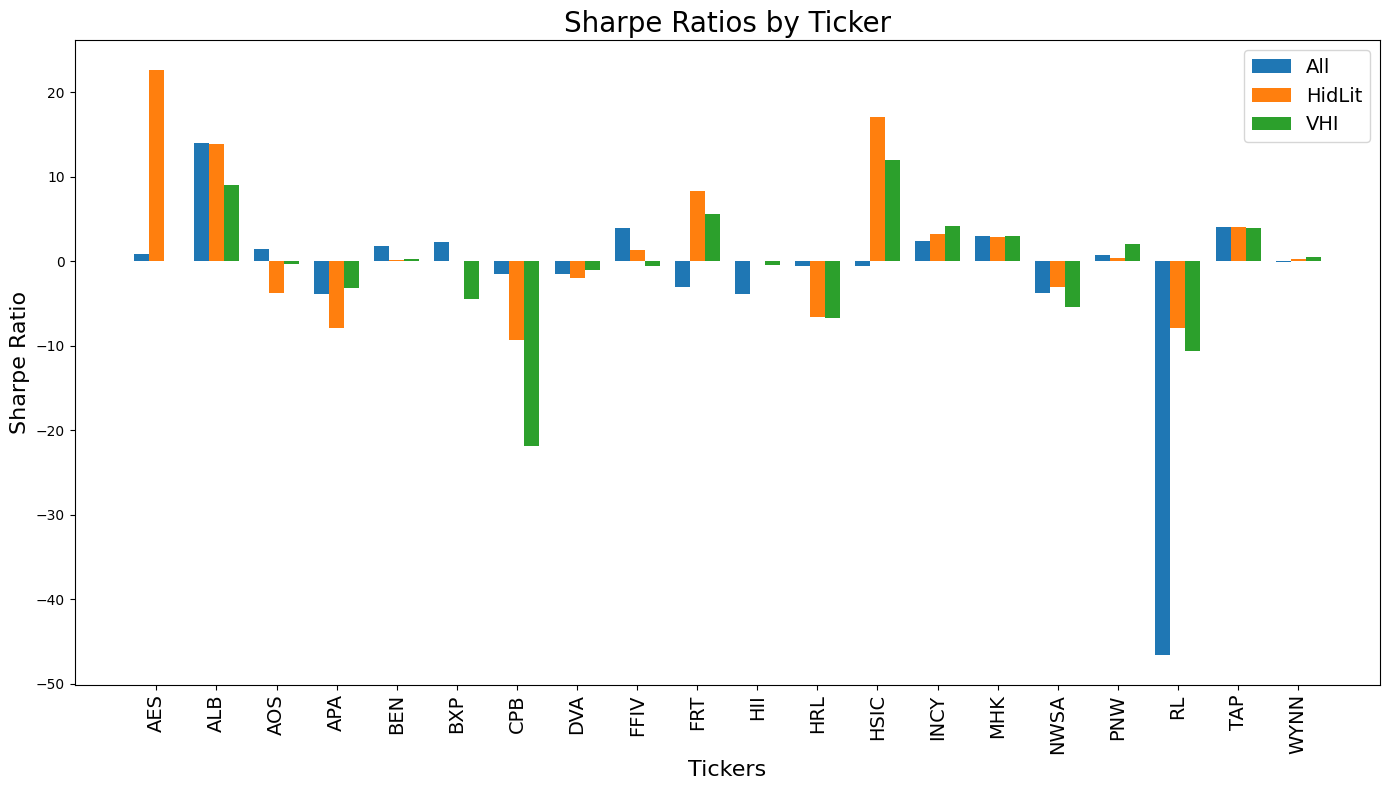

In [327]:
# Assuming df is your dataframe
df_SR = df[['SR_All', 'SR_HidLit', 'SR_VHI']]

# Define the position of each group of bars on the x-axis
x = np.arange(len(df_SR.index))

# Define the width of each bar
bar_width = 0.25

# Create the plot
fig, ax = plt.subplots(figsize=(14, 8))

# Plotting each SR column as a set of bars
ax.bar(x - bar_width, df_SR['SR_All'], width=bar_width, label='All')
ax.bar(x, df_SR['SR_HidLit'], width=bar_width, label='HidLit')
ax.bar(x + bar_width, df_SR['SR_VHI'], width=bar_width, label='VHI')

# Add some text for labels, title, and axes ticks
ax.set_xlabel('Tickers', fontsize=16)
ax.set_ylabel('Sharpe Ratio', fontsize=16)
ax.set_title('Sharpe Ratios by Ticker', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(df_SR.index, rotation=90, fontsize=14)  # Set the ticker names as labels

# Add a legend
ax.legend(fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Assuming df is your dataframe
df_counts = df['count_All', 'count_HidLit', 'count_VHI']

# Define the position of each group of bars on the x-axis
x = np.arange(len(df_SR.index))

# Define the width of each bar
bar_width = 0.25

# Create the plot
fig, ax = plt.subplots(figsize=(14, 8))

# Plotting each SR column as a set of bars
ax.bar(x - bar_width, df_SR['SR_All'], width=bar_width, label='All')
ax.bar(x, df_SR['SR_HidLit'], width=bar_width, label='HidLit')
ax.bar(x + bar_width, df_SR['SR_VHI'], width=bar_width, label='VHI')

# Add some text for labels, title, and axes ticks
ax.set_xlabel('Tickers', fontsize=16)
ax.set_ylabel('Sharpe Ratio', fontsize=16)
ax.set_title('Sharpe Ratios by Ticker', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(df_SR.index, rotation=90, fontsize=14)  # Set the ticker names as labels

# Add a legend
ax.legend(fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()